In [3]:
#!conda install -n mldds -c anaconda joblib
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

import multiprocessing
num_cores = multiprocessing.cpu_count()

print("Cores: ", num_cores)

import time
import keras
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': num_cores} )
sess = tf.Session(config=config) 
keras.backend.set_session(sess)



Cores:  12


In [6]:
import pandas as pd
import numpy as np
from sklearn import utils, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.pyplot import figure
from functools import reduce
from keras.utils import to_categorical
import matplotlib.pyplot as plt


class MyTotoResearch:
    
    @classmethod
    def __init__(self, algo_no=0, inputPPFile='../input/PPv3.csv', inputTotoResult='../input/SGH.csv'):
        self.algo_number = algo_no
        print('Loaded MyTotoResearch algo_no: ', self.algo_number)

    @classmethod
    def load_totodata(self, inputPPFile='../input/PPv3.csv', inputTotoResult='../input/SGH.csv'):
        pp = pd.read_csv(inputPPFile)
        lr = pd.read_csv(inputTotoResult)
        print(len(lr))
        cols = ['D', 'N1','N2','N3','N4','N5','N6','N7']
        lr = lr[cols]

        #https://pandas.pydata.org/pandas-docs/stable/merging.html
        df = pd.concat([pp, lr], axis=1, sort=False)
        df = df.dropna()
        df.reset_index().drop(['D'], axis=1)

#         print(df.shape)
#         counts = [df['N'+str(i)].value_counts() for i in range(1,8)]
#         for i in range(len(counts)):
#             df = df[~df['N'+str(i+1)].isin(counts[i][counts[i] <= 3].index)]
#         print('After removing numbers that have shown 3 or less times')
#         print(df.shape)

        cols = ['N1','N2','N3','N4','N5','N6','N7']
        lr = df[cols]

        self.df = df
        self.lresult = np.sort(lr.values[:, ::-1])
        return self.lresult, self.df 
    
    @classmethod
    def modified_dataset ( self, dataset ):
        self.dataset = dataset
        return self.dataset
    
    @classmethod
    def get_result_n(self, col_n):
        aa = np.delete(self.lresult, np.s_[col_n:], axis=1)  
        aa = np.delete(aa, np.s_[0:col_n-1], axis=1)  
        return pd.DataFrame(aa, columns=list('N'))

    @classmethod
    def get_result_n_encoded(self, col_n):
        aa = np.delete(self.lresult, np.s_[col_n:], axis=1)  
        aa = np.delete(aa, np.s_[0:col_n-1], axis=1)  
        # 1. INSTANTIATE
        enc = preprocessing.OneHotEncoder()

        # 2. FIT
        enc.fit(aa)

        # 3. Transform
        onehotlabels = enc.transform(aa).toarray()
        onehotlabels.shape
        #print(onehotlabels)

        #Convert 2d array to Dataframe
        y = pd.DataFrame(aa, columns=list('N'))
        y.head()
        y = aa.astype(int).ravel()
    #    print ( y )
        return y
        
    @classmethod
    def get_test_data(self, file_name = '../input/PPv3-Predict.csv' ):
        self.data2Predict = pd.read_csv(file_name)
        self.data2Predict.reset_index()
        return self.data2Predict
    

    @classmethod
    def plot_history(self, history):
        loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
        val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
        acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
        val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

        if len(loss_list) == 0:
            print('Loss is missing in history')
            return 

        ## As loss always exists
        epochs = range(1,len(history.history[loss_list[0]]) + 1)

        ## Loss
        figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.figure(1)
        for l in loss_list:
            plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
        for l in val_loss_list:
            plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        ## Accuracy
        plt.figure(1)
        for l in acc_list:
            plt.plot(epochs, history.history[l], 'r', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
        for l in val_acc_list:    
            plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    @classmethod
    def save_model(self, model, predict_number):
        # serialize model to JSON
        model_json = model.to_json()
        with open(str(self.algo_number) + '_' + str(predict_number) + "_model.json", "w") as json_file:
            json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

        # serialize weights to HDF5
        model.save_weights(str(self.algo_number) + '_' + str(predict_number) + "_model.h5")
        print("Saved model to disk ", self.algo_number, " Predict #N ", predict_number)

    @classmethod
    def print_result(self, predicted_values ):
        test_df = pd.read_csv('../input/TestResult.csv', sep='\s+', header=None, names=['D','N1','N2','N3','N4','N5','N6','N7'])
        test_df['D'].replace(regex=True,inplace=True,to_replace=r'-',value=r'')
        test_df['D'] = pd.to_numeric(test_df['D'])

        cols = ['D', 'N1','N2','N3','N4','N5','N6','N7']
        test_df = self.data2Predict.merge(test_df, left_on='T', right_on='D', how='inner')
        test_df = test_df[cols]

        tdfResult = predicted_values.drop(predicted_values.columns[0], axis=1) ;

        actual_result = test_df[cols[1:]].values
        predicted_result = tdfResult.values

        matched = getIntersection(actual_result, predicted_result)

        c = 0
        for i in range(len(matched)):
            print(int(self.data2Predict.loc[i]['T']), ' ', actual_result[i], ' ', predicted_result[i], ' ', matched[c])
            c += 1
        for i in range(c, len(predicted_result)):
            print(int(self.data2Predict.loc[i]['T']), ' Predicted: ', predicted_result[i], ' ')

    @classmethod
    def load_model(self, predict_number):
        json_file = open(str(self.algo_number) + "_" + str(predict_number)+'_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)

        # load weights into new model
        loaded_model.load_weights(str(self.algo_number) + "_" + str(predict_number)+"_model.h5")
        print("Loaded model from disk " + str(self.algo_number) + "_" + str(predict_number) + "_model" )
        return loaded_model

    @staticmethod
    def getIntersection(p1, p2):
        return [reduce(np.intersect1d, (p.astype(int), a.astype(int))) for (p,a) in zip(p1, p2)]

    @classmethod
    def print_predictions(self, dfPredictions, result='../input/TestResult.csv'):
        #load the test Toto Results files
        test_df = pd.read_csv(result, sep='\s+', header=None, names=['D','N1','N2','N3','N4','N5','N6','N7'])
        test_df['D'].replace(regex=True,inplace=True,to_replace=r'-',value=r'')
        test_df['D'] = pd.to_numeric(test_df['D'])

        #Merge the Planet Position File with the Toto Results file
        test_df = self.data2Predict.merge(test_df, left_on='T', right_on='D', how='inner')

        #Extract only the Results for all dates
        cols = ['D', 'N1','N2','N3','N4','N5','N6','N7']
        test_df = test_df[cols]

        tdfResult = dfPredictions.drop(dfPredictions.columns[0], axis=1) ;

        actual_result = test_df[cols[1:]].values
        predicted_result = tdfResult.values

        matched = MyTotoResearch.getIntersection(actual_result, predicted_result)

        c = 0
        for i in range(len(matched)):
            print(int(self.data2Predict.loc[i]['T']), ' ', actual_result[i], ' ', predicted_result[i], ' ', matched[c])
            c += 1
        for i in range(c, len(predicted_result)):
            print(int(self.data2Predict.loc[i]['T']), ' Predicted: ', predicted_result[i], ' ')

            
def getAdjustedDataF(df,f):
    #Use only Planet Positions Testing
    cols = ['L','M','S', 'R','E','A','V' ,'J','U','K']
    X = df[cols]
    deg = f
    
#     X['S_3'] = X['S'] // (deg*3)
#     X['L_3'] = X['L'] // (deg*3)
#     X['M_3'] = X['M'] // (deg*3)
#     X['R_3'] = X['R'] // (deg*3)
#     X['E_3'] = X['E'] // (deg*3)
#     X['A_3'] = X['A'] // (deg*3)
#     X['V_3'] = X['V'] // (deg*3)
#     X['J_3'] = X['J'] // (deg*3)
#     X['U_3'] = X['U'] // (deg*3)


#     X['S_2'] = X['S'] // (deg*2)
#     X['L_2'] = X['L'] // (deg*2)
#     X['M_2'] = X['M'] // (deg*2)
#     X['R_2'] = X['R'] // (deg*2)
#     X['E_2'] = X['E'] // (deg*2)
#     X['A_2'] = X['A'] // (deg*2)
#     X['V_2'] = X['V'] // (deg*2)
#     X['J_2'] = X['J'] // (deg*2)
#     X['U_2'] = X['U'] // (deg*2)

    X['S_1'] = X['S'] // (deg)
    X['L_1'] = X['L'] // (deg)
    X['M_1'] = X['M'] // (deg)
    X['R_1'] = X['R'] // (deg)
    X['E_1'] = X['E'] // (deg)
    X['A_1'] = X['A'] // (deg)
    X['V_1'] = X['V'] // (deg)
    X['J_1'] = X['J'] // (deg)
    X['U_1'] = X['U'] // (deg)
   
    X = X.drop(cols, axis=1)
    return X




<>:138: DeprecationWarning: invalid escape sequence \s


In [7]:
from keras.callbacks import EarlyStopping 

class MyEarlyStopping(EarlyStopping):
    def __init__(self, threshold, **kwargs):
        super(MyEarlyStopping, self).__init__(**kwargs)
        self.threshold = threshold # threshold for validation loss

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
            return

        # implement your own logic here
        if (current >= self.threshold):
            self.stopped_epoch = epoch
            self.model.stop_training = True
            
class MyEarlyStoppingLoss(EarlyStopping):
    def __init__(self, threshold, **kwargs):
        super(MyEarlyStoppingLoss, self).__init__(**kwargs)
        self.threshold = threshold # threshold for validation loss

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
            return

        # implement your own logic here
        if (current <= self.threshold):
            self.stopped_epoch = epoch
            self.model.stop_training = True

Loaded MyTotoResearch algo_no:  1
1521


/Users/walter/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


1 Time taken:  15875.611630999996  


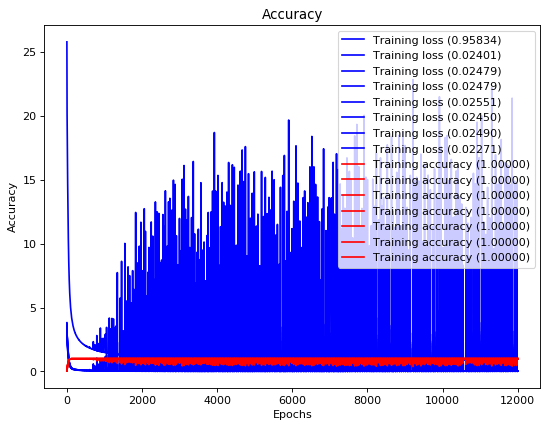

In [19]:
from keras.models import Input, Model
import keras
from keras.layers import Dense
import time
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
import json as simplejson
from keras import regularizers
from sklearn import preprocessing


def getAllData(df):
    drop_cols = ['T', 'D', 'N1','N2','N3','N4','N5','N6','N7','L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X


early_stopping = MyEarlyStopping ( threshold=.99999, monitor='acc', verbose=1 )
#early_stopping_loss = MyEarlyStoppingLoss ( threshold=.005, monitor='loss', verbose=1 )



#Deep Neuro Network
mtr = MyTotoResearch(algo_no=1)
lresult, df = mtr.load_totodata()
#for z in range(9,91,3):
for z in range(1,2):
#    33, 42
    f = 365/33
    X = mtr.modified_dataset(getAllData(df)) #
#    X = mtr.modified_dataset(getAdjustedDataF(df,f))

    target = [to_categorical(mtr.get_result_n(i)) for i in range(1,8)]

    inputs = Input(shape=(X.shape[1],))
    input_layer = Dense(2000, activation='tanh', kernel_regularizer=regularizers.l2(0.00001))(inputs)
#    input_layer = Dense(1200, activation='tanh')(input_layer)
#     input_layer = Dense(1200, activation='relu')(input_layer)


    output_layers = []
    for n in range(1,8):
        output_layers.append(Dense(target[n-1].shape[1], activation='softmax', name='N'+str(n))(input_layer))

    # model trained on both outputs
    model = Model(input=inputs, output=output_layers)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

    start = time.clock()
    history = model.fit(X, target, epochs=12000, verbose=0) #, callbacks=[early_stopping]) #, callbacks=[early_stopping]) #, checkpoint])    
    print(str(z) + " Time taken: ", (time.clock() - start),  " ")

    mtr.plot_history(history)

#    test_data = mtr.get_test_data()
#    X = mtr.modified_dataset(getAdjustedDataF(test_data,f))

#    predictions = model.predict(X)


In [66]:
def getAllData(df):
    drop_cols = ['T', 'D', 'N1','N2','N3','N4','N5','N6','N7','L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X

print(getAllData(df).shape)

(1521, 40)


In [18]:
from keras.utils import np_utils

def getAllData(df):
    drop_cols = ['T', 'L','M','S','R','E','A','V' ,'J','U','K']
    X = df.drop(drop_cols, axis=1)
    return X

mtr = MyTotoResearch(algo_no=1)
lresult, df = mtr.load_totodata()

print(df.shape)
print(X.shape)
test_data = mtr.get_test_data()
X = mtr.modified_dataset(getAllData(test_data)) #
#X = mtr.modified_dataset(getAdjustedDataF(test_data,f))

predictions = model.predict(X)

dfResult = pd.DataFrame(test_data['T'])
for i in range(len(predictions)):
    s = 'N' + str(i+1)
    dfPN = pd.DataFrame({s:predictions[i].argmax(axis=-1)})
    dfResult = pd.concat([dfResult, dfPN], axis=1)

#print(dfResult)
mtr.print_predictions(dfResult)


Loaded MyTotoResearch algo_no:  1
1521
(1521, 59)
(1521, 40)
20180514   [17 24 29 45 46 49  5]   [ 1 16 21 22 24 25 27]   [24]
20180517   [ 7 21 25 29 35 37 13]   [ 6 16 17 34 40 44 48]   []
20180521   [ 8 10 16 30 37 44 17]   [ 2  6  9 15 18 40 43]   []
20180524   [11 25 26 34 36 42 16]   [ 2 15 17 20 23 30 45]   []
20180528   [ 5  9 27 28 30 44  2]   [ 3  4  5 13 18 39 40]   [5]
20180531   [11 13 24 26 47 49 33]   [ 3  9 27 29 31 40 46]   []
20180604   [20 22 31 37 43 45 27]   [ 5  6 16 24 26 29 38]   []
20180607   [12 20 29 31 37 39 42]   [ 2  3 19 23 30 39 41]   [39]
20180611   [16 25 30 37 44 49 34]   [ 2  9 10 25 38 40 42]   [25]
20180614   [ 4 29 31 35 42 48  1]   [20 22 23 25 32 33 36]   []
20180618   [11 15 22 23 26 43 25]   [ 1  3  6 16 17 22 36]   [22]
20180621   [ 4  6 15 24 30 35 46]   [13 16 20 23 28 39 42]   []
20180625   [ 2  5 25 38 44 48  9]   [ 7 15 18 20 27 36 40]   []
20180628   [ 2  7 22 27 40 47 48]   [ 1 10 15 27 35 41 46]   [27]
20180702   [12 13 26 33 35 38 23

In [ ]:
df['N1'].value_counts().plot(kind="bar")

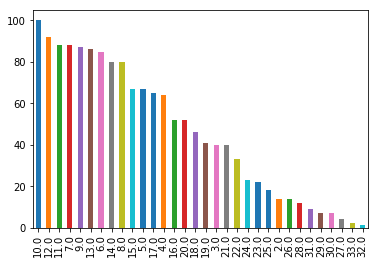

In [146]:
df['N2'].value_counts().plot(kind="bar")

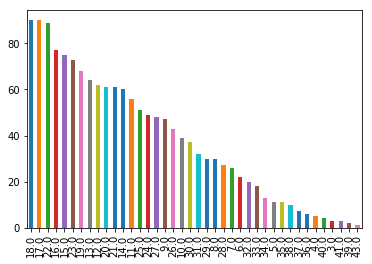

In [93]:
df['N3'].value_counts().plot(kind="bar")

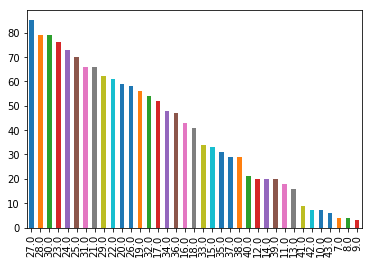

In [147]:
df['N4'].value_counts().plot(kind="bar")

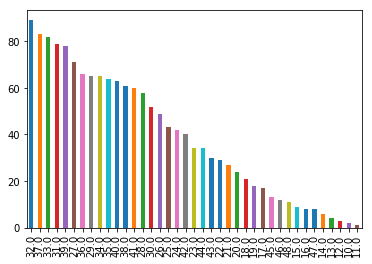

In [95]:
df['N5'].value_counts().plot(kind="bar")

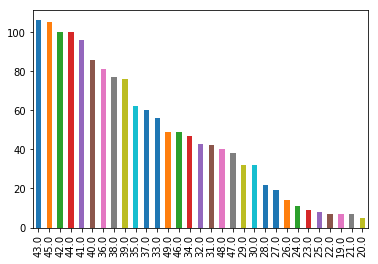

In [148]:
df['N6'].value_counts().plot(kind="bar")

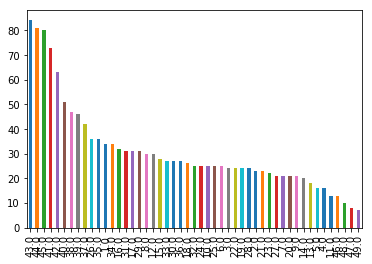

In [97]:
df['N7'].value_counts().plot(kind="bar")